In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb

from scipy.stats import chi2

import copy

# Problem 1

In [2]:
# ------ Copy-pasted from planck_likelihood.py ----------------------------------------------------------------

def get_spectrum(pars,lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2:]


pars=np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3])
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
dof = len(resid)-len(pars)
print("chisq is ",chisq," for ",dof,"degrees of freedom. Using",list(pars))

# --------------------------------------------------------------------------------------------------------------------

# Now use new parameters

newpars = np.asarray([69, 0.022, 0.12, 0.06, 2.1e-9, 0.95])
newmodel = get_spectrum(newpars)
newmodel = newmodel[:len(spec)]
newres = spec-newmodel
newchisq = np.sum((newres/errs)**2)
print("chisq is",newchisq,"for",dof,"degrees of freedom. Using",list(newpars))

# In order to determine if these are 'good' chi-squared values, find the p-value

p1 = chi2.sf(chisq,dof)
p2 = chi2.sf(newchisq,dof)

print("\nThe p-value for",list(pars),"is",p1)
print("The p-value for",list(newpars),"is",p2)

chisq is  15264.645406788037  for  2501 degrees of freedom. Using [60.0, 0.02, 0.1, 0.05, 2e-09, 1.0]
chisq is 3272.5723646011556 for 2501 degrees of freedom. Using [69.0, 0.022, 0.12, 0.06, 2.1e-09, 0.95]

The p-value for [60.0, 0.02, 0.1, 0.05, 2e-09, 1.0] is 0.0
The p-value for [69.0, 0.022, 0.12, 0.06, 2.1e-09, 0.95] is 1.100148080038718e-23


# Problem 2

The p-value for best-fit parameters [68.53646002744289, 0.022426666983370813, 0.1168481352348479, 0.00730866986385691, 1.8962720817833285e-09, 0.9724003484485261] is 0.11948068681689408
The final chi-square value is 2584.532036621591


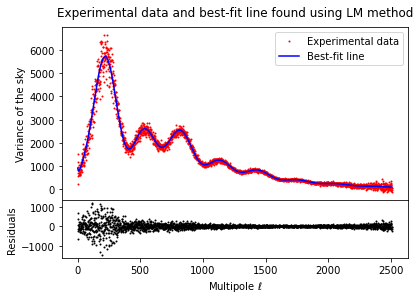

In [3]:
# Use Levenberg-Marquardt method to find best-fit parameters

# First, define a function that takes the gradient:

def grad(fun, params, delta):
    ''' Use numerical differentiator from problem set 1 problem 1
    Tweak it a little so it returns the gradient
    Here delta is an ARRAY --> different delta for each parameter'''
    
    gradient = np.zeros([2507,params.size])  # 2507 is the size of our experimental dataset
    
    # Take the derivative of ONE parameter at a time --> iterate over parameters
    for i,par in enumerate(params):
        
        par_plus = copy.deepcopy(params)
        par_2plus = copy.deepcopy(params)
        par_minus = copy.deepcopy(params)
        par_2minus = copy.deepcopy(params)
        
        par_plus[i] += delta[i]
        par_2plus[i] += 2*delta[i]
        par_minus[i] -= delta[i]
        par_2minus[i] -= 2*delta[i]
        
        # Take derivative from param+-delta
        deriv_1 = (fun(par_plus) - fun(par_minus))/(2*delta[i])
        
        # Take derivative from param+-2delta
        deriv_2 = (fun(par_2plus) - fun(par_2minus))/(4*delta[i])
        
        # Combine them
        deriv = 4/3 * deriv_1 - 1/3 * deriv_2
        
        # Stick them to the gradient
        gradient[:,i] = deriv[:2507]
        
    return gradient


def update_lambda(lamb, success):
    ''' From lm_class.py (seen in class) '''
    if success:
        lamb = lamb/1.5
        if lamb<0.5:
            lamb=0
    else:
        if lamb==0:
            lamb=1
        else:
            lamb = lamb*1.5**2
    return lamb


def fit_lm(fun, params, data, errs, delta, niter=50):
    ''' Adapted from lm_class.py (seen in class) '''
    
    # Initialize noise matrix
    N = np.zeros((2507,2507))
    for i in range(len(N)):
        N[i,i] = errs[i]
    
    lamb = 0
    # Get first chi-square value with guess parameters
    model = fun(params)[:2507]
    chisq_old = np.sum(((model-data)/errs)**2)
    
    for i in range(niter):
        
        # Calculate model and local gradient
        model = fun(params)[:2507]
        gradient = grad(fun, params, delta)
        
        # Calculate residuals
        r = data - model
        
        # Initialize left-hand-side and right-hand-side in linear algebra problem
        lhs = gradient.T@np.linalg.inv(N)@gradient
        lhs = lhs + lamb*np.diag(np.diag(lhs))  # Do the lambda thing for Levenberg-Marquardt
        
        rhs = gradient.T@np.linalg.inv(N)@r
        
        # Ideally use inverse, but make it fail-proof in case of uninvertible matrix
        try:
            curvature_matrix = np.linalg.inv(lhs)
        except:
            curvature_matrix = np.linalg.pinv(lhs)
            
        dm = curvature_matrix@rhs
        
        # Check out how the step we just took works
        p_trial = params + dm
        model = fun(p_trial)[:2507]
        chisq = np.sum(((data-model)/errs)**2)
        
        # Decide whether to accept the step or not
        if (chisq<chisq_old):
            lamb = update_lambda(lamb, True)
            params += dm
            chisq_old = chisq
        else:
            lamb = update_lambda(lamb, False)
            
    return params, chisq, curvature_matrix

    
# Define a delta array to calculate the gradient (just go a few orders of magnitude below the corresponding param value)
delta = np.asarray([1e-2, 1e-5, 1e-4, 1e-5, 1e-12, 1e-4])

# Start with a guess for parameters (use second set of parameters presented in problem set)
pars_guess = np.asarray([69, 0.022, 0.12, 0.06, 2.1e-9, 0.95])

# Get the best-fit LM parameters and the chi-square
best_pars, best_chisq, curvmat = fit_lm(get_spectrum, pars_guess, spec, errs, delta)

# Get the p-value
p_final = chi2.sf(best_chisq,dof)

print("The p-value for best-fit parameters",list(best_pars),"is",p_final)
print("The final chi-square value is",best_chisq)


# Plot my best-fit parameters to see if it looks good

best_data = get_spectrum(best_pars)[:2507]

fig = plt.figure(0)

top = fig.add_axes((.1,.3,.8,.6))
plt.plot(ell, spec, '.', markersize=2, color='red', label="Experimental data")
plt.plot(ell, best_data, color='blue',label="Best-fit line")
plt.legend()
plt.ylabel("Variance of the sky")
plt.title("Experimental data and best-fit line found using LM method",y=1.03)

res = spec-best_data
bot = fig.add_axes((.1,.1,.8,.2))
plt.plot(ell,res, '.', markersize=2, color='k')
plt.ylabel("Residuals")
plt.xlabel(r"Multipole $\ell$")

#plt.savefig("multipole_with_res.png",dpi=500,bbox_inches='tight')

plt.show()


# Finally, insert everything into a text file

param_errs = np.sqrt(np.diag(curvmat))
param_name_list = ["Hubble constant","Baryon density","Dark matter density","Optical depth",\
                   "Primordial amplitude of the spectrum","Primordial tilt of the spectrum"]

with open("planck_fit_params.txt",'w') as f:
    f.write("Parameter name\tParameter value\tParameter uncertainty\n")
    for i,c in enumerate(best_pars):
        f.write(f"{param_name_list[i]}\t{c}\t{param_errs[i]}\n")

# Problem 3

Bayes' Theorem:

\begin{equation}
P(d|\theta) \propto P(\theta|d) P(d)
\end{equation}

$d$: data points\
$\theta$: model

In [ ]:
# First define a prior on my parameters
# I will define a flat (uniform) prior with lower and upper limits dictated by the curvature matrix from Problem 2

# Use Metropolis-Hastings algorithm